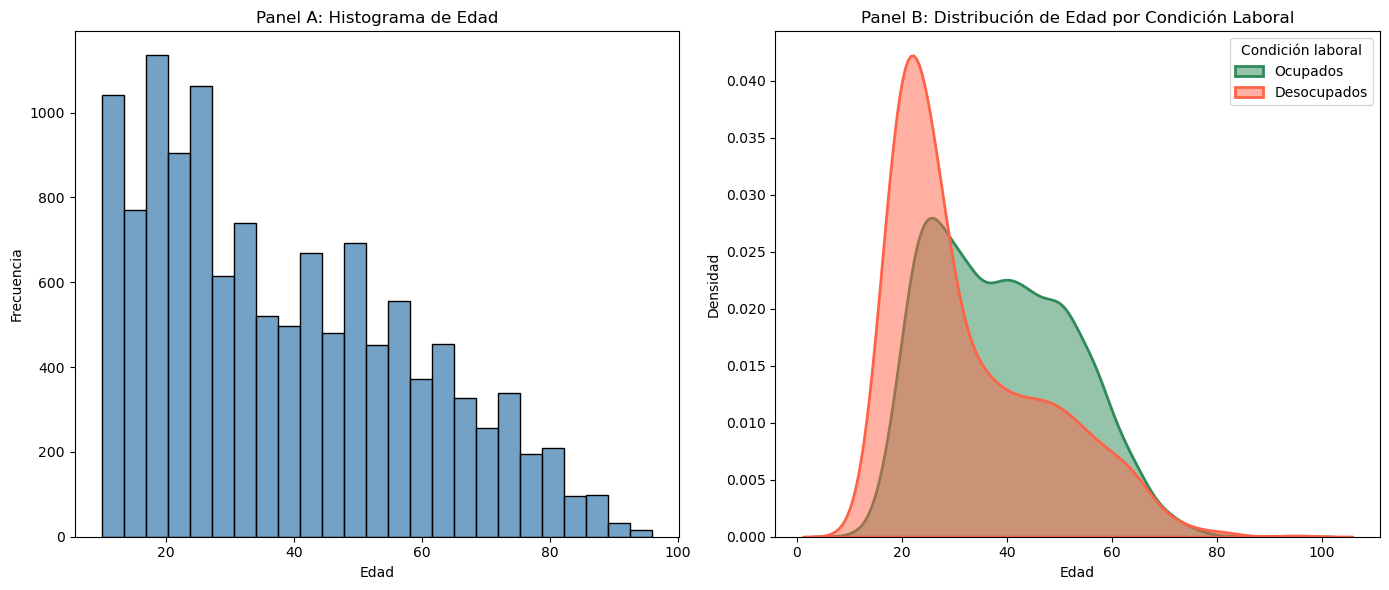

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivo
df = pd.read_excel("resultado_pampeana09.xlsx")

# Filtrar por años 2004 y 2024
df = df[df["ano4"].isin([2004, 2024])].copy()

# Normalizar sexo
def normalizar_ch04(valor, año):
    if año == 2004:
        if str(valor).strip().lower() in ["varón", "hombre", "m"]:
            return "Hombre"
        elif str(valor).strip().lower() in ["mujer", "f"]:
            return "Mujer"
    elif año == 2024:
        if valor == 1:
            return "Hombre"
        elif valor == 2:
            return "Mujer"
        elif valor == 3:
            return "Otro"
    return None

df["sexo"] = df.apply(lambda row: normalizar_ch04(row["CH04"], row["ano4"]), axis=1)

# Edad válida
df["edad"] = pd.to_numeric(df["CH06"], errors="coerce")
df = df[df["edad"].notna() & (df["edad"] >= 10)]

# Edad al cuadrado
df["edad2"] = df["edad"] ** 2

# Unificar columna ESTADO según año
def normalizar_estado(row):
    if row["ano4"] == 2004:
        val = str(row["ESTADO"]).strip().lower()
        if val == "ocupado":
            return "Ocupado"
        elif val == "desocupado":
            return "Desocupado"
        elif val == "inactivo":
            return "Inactivo"
    elif row["ano4"] == 2024:
        val = row["ESTADO"]
        if val == 1:
            return "Ocupado"
        elif val == 2:
            return "Desocupado"
        elif val == 3:
            return "Inactivo"
    return None

df["cond_laboral"] = df.apply(normalizar_estado, axis=1)

# Filtrar solo ocupados y desocupados
df_od = df[df["cond_laboral"].isin(["Ocupado", "Desocupado"])]

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Histograma
sns.histplot(df["edad"], bins=25, color="steelblue", ax=axes[0])
axes[0].set_title("Panel A: Histograma de Edad")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Frecuencia")

# Panel B: KDE
sns.kdeplot(
    data=df_od[df_od["cond_laboral"] == "Ocupado"],
    x="edad",
    label="Ocupados",
    fill=True,
    color="seagreen",
    alpha=0.5,
    linewidth=2,
    warn_singular=False,
    ax=axes[1]
)
sns.kdeplot(
    data=df_od[df_od["cond_laboral"] == "Desocupado"],
    x="edad",
    label="Desocupados",
    fill=True,
    color="tomato",
    alpha=0.5,
    linewidth=2,
    warn_singular=False,
    ax=axes[1]
)
axes[1].set_title("Panel B: Distribución de Edad por Condición Laboral")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Densidad")
axes[1].legend(title="Condición laboral")

plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np

# Cargar archivo
df = pd.read_excel("resultado_pampeana091.xlsx")
df = df[df["ano4"].isin([2004, 2024])].copy()

# Limpiar campos texto
for col in ["CH12", "CH13", "CH14"]:
    df[col] = df[col].astype(str).str.strip().str.lower().replace({"nan": np.nan, "": np.nan})

# Función para calcular educ
def calcular_educ(row):
    ch12 = row["CH12"]
    ch13 = row["CH13"]
    ch14 = row["CH14"]
    año = row["ano4"]

    if pd.isna(ch12):
        return np.nan

    # BASE por nivel educativo
    base = 0

    if año == 2024:
        try:
            ch12 = int(ch12)
        except:
            return np.nan

        if ch12 in [1]: base = 0  # jardín
        elif ch12 in [2, 3]: base = 0  # primario / EGB
        elif ch12 in [4, 5]: base = 7
        elif ch12 == 6: base = 13
        elif ch12 == 7: base = 13
        elif ch12 == 8: base = 17
        else: return np.nan

    elif año == 2004:
        if "jard" in ch12 or "preescolar" in ch12:
            base = 0
        elif "primario" in ch12:
            base = 0
        elif "egb" in ch12:
            base = 0
        elif "secundario" in ch12 or "polimodal" in ch12:
            base = 7
        elif "terciario" in ch12:
            base = 13
        elif "universitario" in ch12:
            base = 13
        elif "posgrado" in ch12:
            base = 17
        else:
            return np.nan

    # Año aprobado
    try:
        aprobado = int(ch14)
        if aprobado in range(1, 10):
            adicional = aprobado
        else:
            adicional = 0
    except:
        adicional = 0

    # Finalizó?
    finalizo = str(ch13).lower()
    extra = 1 if finalizo in ["sí", "si", "s", "1"] else 0

    return base + adicional + extra

# Calcular
df["educ"] = df.apply(calcular_educ, axis=1)

# Estadísticas descriptivas
educ_stats = df["educ"].dropna().describe(percentiles=[0.5])[["mean", "std", "min", "50%", "max"]]
educ_stats.rename(index={"50%": "p50"}, inplace=True)
print(educ_stats)


mean     6.551599
std      5.281008
min      0.000000
p50      7.000000
max     20.000000
Name: educ, dtype: float64


###Media (mean): El valor promedio de años de educación es de 6.55 años. Esto significa que, en promedio, las personas de la muestra han completado alrededor de 6 años de escolaridad formal, lo cual es una mezcla de niveles educativos, con muchos individuos que quizás no han terminado la secundaria o que se encuentran en la transición entre niveles educativos.

Desviación estándar (std): La desviación estándar es 5.28, lo que indica que hay una considerable dispersión entre los años de educación de las personas en la muestra. Esto sugiere que hay tanto individuos con baja educación (menos de 5 años) como aquellos con una educación más avanzada (más de 10 o 15 años). Es decir, la muestra tiene una gran variabilidad en los niveles educativos.

Mínimo (min): El valor mínimo es 0, lo que indica que hay individuos que no han cursado ningún nivel educativo. Esto podría ser el caso de personas muy jóvenes o de aquellos que, por diversas razones, no han asistido a la escuela.

Mediana (p50): El valor de la mediana es 7 años, lo que significa que la mitad de los individuos de la muestra tienen 7 años o menos de educación formal. Este es un indicador clave de la distribución, mostrando que, en general, muchos de los encuestados no han completado la educación secundaria.

Máximo (max): El valor máximo es 20 años, lo que representa el caso de una persona que ha completado, por ejemplo, una educación universitaria completa, incluyendo un posgrado o especialización. Esto también muestra que la muestra tiene personas con niveles educativos muy altos.

Resumen:
La distribución de los años de educación es bastante dispersa. Si bien la media está en 6.55 años, la mediana (7 años) nos indica que hay una gran cantidad de personas con niveles educativos cercanos a la secundaria, pero también existen individuos con niveles educativos significativamente más altos, lo que refleja la diversidad en el acceso a la educación en tu muestra. La desviación estándar también muestra que esta variabilidad es notable.

Conclusión:
Este análisis refleja que, a pesar de que la mayoría de las personas en la muestra tienen alrededor de 7 años de escolaridad (es decir, secundaria incompleta o completa), existe una heterogeneidad significativa, con personas que tienen tanto una educación baja como avanzada. Esto podría deberse a diferencias en el acceso a la educación, edad de los encuestados, y las posibilidades de continuar la educación más allá del nivel básico.

 

In [4]:
#PUNTO 3

import pandas as pd

# Cargar el archivo
df = pd.read_excel("resultado_pampeana0911.xlsx")

# Filtrar por años 2004 y 2024
df = df[df["ano4"].isin([2004, 2024])].copy()

# Asegurar que las columnas sean numéricas
df["PP3E_TOT"] = pd.to_numeric(df["PP3E_TOT"], errors="coerce")
df["PP3F_TOT"] = pd.to_numeric(df["PP3F_TOT"], errors="coerce")

# Crear variable horastrab (ocupación principal + secundaria)
df["horastrab"] = df["PP3E_TOT"] + df["PP3F_TOT"]

# Filtrar: solo valores entre 1 y 100 horas semanales
df_filtrado = df[(df["horastrab"] > 0) & (df["horastrab"] <= 100)]

# Estadística descriptiva
stats = df_filtrado["horastrab"].describe(percentiles=[0.5])[["mean", "std", "min", "50%", "max"]]
stats.rename(index={"50%": "p50"}, inplace=True)

# Mostrar resultados
print(stats)

mean     40.619669
std      19.458817
min       1.000000
p50      40.000000
max     100.000000
Name: horastrab, dtype: float64


### Luego de limpiar los datos y quedarnos únicamente con las observaciones que reportaron una cantidad lógica de horas trabajadas (entre 1 y 100 horas semanales), se obtuvieron estadísticas descriptivas más representativas de la población ocupada. El promedio de horas trabajadas por semana se ubicó en aproximadamente 40,6 horas, con una mediana de 40 horas, lo cual indica que la mayoría de los trabajadores desempeñan jornadas laborales cercanas al estándar de tiempo completo.

La desviación estándar, de 19,5 horas, sugiere una considerable variabilidad en las cargas horarias, reflejando la coexistencia de distintas modalidades de empleo, como trabajo part-time, empleo informal o pluriempleo. El mínimo registrado fue de 1 hora semanal, lo cual puede responder a empleos muy esporádicos, mientras que el máximo de 100 horas podría estar vinculado a personas con múltiples ocupaciones o a situaciones de subregistro en los cuestionarios.

En resumen, estos valores ofrecen una mirada más precisa del régimen laboral semanal entre los ocupados, eliminando el sesgo que podría introducirse por errores de carga o la inclusión de personas inactivas o desocupadas. Esto permite realizar inferencias más ajustadas respecto al esfuerzo laboral y sus posibles implicancias en términos de bienestar y calidad de vida.